In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "1_raw")
out= os.join(root, "data", "2_intermediate")

In [4]:
import psycopg2 as psy
# load furman db
connection = psy.connect(
    host="fcdata.c7h93yqbqnvu.us-east-1.rds.amazonaws.com",
    port=5432,
    user = "furmandata",
    password = config.furman_pwd,
    database = "fcdata")
cursor = connection.cursor()

## Calculate catchment for alarm boxes

In [3]:
firecomp= gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Fire_Companies/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")
firecomp

firebat= gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Fire_Battalions/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")
firebat

firediv= gpd.read_file("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Fire_Divisions/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")
firediv

,OBJECTID,FireDiv,Shape__Area,Shape__Length,geometry
0,1,7,9.155053e+08,475522.142626,"MULTIPOLYGON (((-73.78922 40.85875, -73.78919 ..."
1,2,3,3.096170e+08,140949.248366,"MULTIPOLYGON (((-73.92134 40.80086, -73.92114 ..."
2,3,1,1.867217e+08,129804.513187,"MULTIPOLYGON (((-74.04398 40.68859, -74.04439 ..."
3,4,15,9.892598e+08,467217.078989,"MULTIPOLYGON (((-73.86328 40.58389, -73.86381 ..."
4,5,11,4.943151e+08,256156.400198,"POLYGON ((-73.95440 40.73912, -73.95428 40.739..."
5,6,13,1.496042e+09,686533.872602,"MULTIPOLYGON (((-73.83193 40.59346, -73.83117 ..."
6,7,14,1.562116e+09,456750.206166,"MULTIPOLYGON (((-73.94180 40.76906, -73.94257 ..."
7,8,8,2.063724e+09,623169.698977,"MULTIPOLYGON (((-74.20313 40.57961, -74.20302 ..."
8,9,6,3.731799e+08,182950.385141,"MULTIPOLYGON (((-73.93516 40.83269, -73.93513 ..."


<AxesSubplot:>

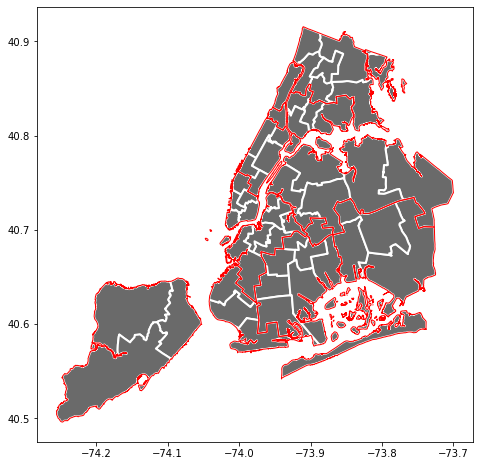

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
firebat.plot(ax=ax, color='#6a6a6a', edgecolor='white', linewidth=2)
firediv.plot(ax=ax, color='none', edgecolor='red')

In [5]:
firevac= pd.read_csv("https://data.cityofnewyork.us/resource/n5xc-7jfa.csv?$limit=100000")
firevac.shape

(93, 19)

In [15]:
alarmbox= gpd.read_file("https://data.cityofnewyork.us/resource/v57i-gtxb.geojson?$limit=100000").to_crs(2263)

<AxesSubplot:>

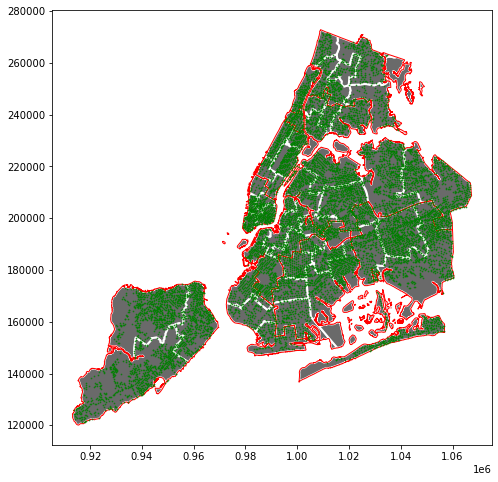

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
firebat.to_crs(2263).plot(ax=ax, color='#6a6a6a', edgecolor='white', linewidth=2)
firediv.to_crs(2263).plot(ax=ax, color='none', edgecolor='red')
alarmbox.plot(ax=ax, color='green', markersize=0.5, alpha = 0.8)

In [14]:
## load pluto data as points
pluto= gpd.GeoDataFrame.from_postgis("""SELECT bbl, 
                                               ct2010,
                                               geom_point FROM mappluto_21v3
                                        WHERE landuse IN ('01', '02', '03', '04')""", connection,
                                    geom_col = "geom_point")

In [16]:
pluto.head()
#alarmbox

,bbl,ct2010,geom_point
0,3042270037,1194,POINT (1018574.470 184812.888)
1,3042670001,1208,POINT (1020385.163 183998.515)
2,3055400063,248,POINT (987459.971 164891.168)
3,3029077506,477,POINT (1000672.538 199913.566)
4,3055440004,250,POINT (985192.814 166406.667)


In [17]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

pluto_borobox= ckdnearest(pluto, alarmbox)

In [87]:
pluto_borobox.head()

,bbl,ct2010,geom_point,location,latitude,zip,borobox,communitydistict,longitude,box_type,citycouncil,borough,dist
0,3042270037,1194,POINT (1018574.470 184812.888),BELMONT AVE & MILFORD ST,40.67338539,11208,B1826,BK05,-73.87680041,ERS,37,Brooklyn,234.277634
1,3042670001,1208,POINT (1020385.163 183998.515),BLAKE AVE & EUCLID AVE,40.67132686,11208,B1838,BK05,-73.87092539,ERS,42,Brooklyn,348.769018
2,3055400063,248,POINT (987459.971 164891.168),20 AVE & 63 ST,40.61768416,11204,B2859,BK11,-73.98465158,ERS,47,Brooklyn,1198.302557
3,3029077506,477,POINT (1000672.538 199913.566),MASPETH AVE & CONSELYEA ST,40.71551913,11211,B0184,BK01,-73.94122766,BARS,34,Brooklyn,139.662288
4,3055440004,250,POINT (985192.814 166406.667),15 AVE & 67 ST,40.62215491,11219,B2805,BK11,-73.9983325,ERS,38,Brooklyn,666.477552


In [88]:
pluto_borobox.to_csv(os.join(out, "pluto_borobox.csv"))
#pluto_borobox.to_file(os.join(out, "pluto_borobox.geojson"), driver = "GeoJSON")

## Create Census Tract Weights

In [3]:
#pluto_borobox = gpd.read_file(os.join(out, "pluto_borobox.geojson"))

In [39]:
plutobox_ct= pd.merge(pluto_borobox.loc[:, ["bbl", "location", "borobox", "box_type", "latitude", "longitude"]],
         pluto.loc[:, ["bbl", "ct2010"]], on = "bbl")

plutobox_ct['boroct2010']= plutobox_ct['bbl'].str[0] + plutobox_ct['ct2010'].astype(str).str.replace(".", "").str.pad(width = 6, fillchar = "0")
plutobox_ct

C:\Users\Jennah\AppData\Local\Temp/ipykernel_30668/3246078852.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  plutobox_ct['boroct2010']= plutobox_ct['bbl'].str[0] + plutobox_ct['ct2010'].astype(str).str.replace(".", "").str.pad(width = 6, fillchar = "0")


,bbl,location,borobox,box_type,latitude,longitude,ct2010,boroct2010
0,3042270037,BELMONT AVE & MILFORD ST,B1826,ERS,40.67338539,-73.87680041,1194,3001194
1,3042670001,BLAKE AVE & EUCLID AVE,B1838,ERS,40.67132686,-73.87092539,1208,3001208
2,3055400063,20 AVE & 63 ST,B2859,ERS,40.61768416,-73.98465158,248,3000248
3,3029077506,MASPETH AVE & CONSELYEA ST,B0184,BARS,40.71551913,-73.94122766,477,3000477
4,3055440004,15 AVE & 67 ST,B2805,ERS,40.62215491,-73.9983325,250,3000250
...,...,...,...,...,...,...,...,...
764555,3054887501,15 AVE & 56 ST,B3794,ERS,40.62844587,-73.99179319,240,3000240
764556,3054951041,AVENUE M & E 5 ST,B2976,ERS,40.61685916,-73.97048282,448,3000448
764557,3055220059,BAY PWAY & 61 ST,B2916,ERS,40.61600744,-73.97899582,246,3000246
764558,3027900031,BUSHWICK AVE & GRAND ST,B0264,BARS,40.71196205,-73.94068803,495,3000495


In [80]:
plutobox_ct_count= plutobox_ct.value_counts(['boroct2010', 'borobox']).rename('count').reset_index()
plutobox_ct_count

,boroct2010,borobox,count
0,3070201,B4116,1614
1,3000336,B3520,836
2,2000516,X4607,694
3,5020803,R4329,661
4,5017007,R3387,660
...,...,...,...
18626,5000279,R2477,1
18627,3000910,B1687,1
18628,3000908,B3930,1
18629,1000182,M1362,1


In [81]:
plutobox_ct_count= pd.merge(plutobox_ct_count,
         plutobox_ct_count.groupby('boroct2010', as_index = False)["count"].sum()\
         .rename({'count':'total'}, axis = 1), on = "boroct2010")
plutobox_ct_count['wgt']= plutobox_ct_count['count'].div(plutobox_ct_count['total'])

In [84]:
plutobox_ct_count

,boroct2010,borobox,count,total,wgt
0,3070201,B4116,1614,1876,0.860341
1,3070201,B3994,228,1876,0.121535
2,3070201,B4103,34,1876,0.018124
3,3000336,B3520,836,913,0.915663
4,3000336,B3522,77,913,0.084337
...,...,...,...,...,...
18626,3000085,B1371,1,4,0.250000
18627,3000085,B3809,1,4,0.250000
18628,3000085,B3829,1,4,0.250000
18629,4097202,Q1247,1,2,0.500000


In [85]:
## save census tract, borobox, weight crosswalk
plutobox_ct_count.to_csv(os.join(out, "ct_box_xwalk.csv"))